In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet

In [2]:
df = pd.read_parquet("meow_df.parquet", engine = 'fastparquet')

df.columns

df['time_diff'] = df.seconds_in_bucket - df.seconds_in_bucket_before

df = df.query("""time_id == time_id_before and stock_id == stock_id_before""")

df = df.drop(columns = ['time_id_before', 'seconds_in_bucket_before', 'stock_id_before', 'level_0'])

df['trade'] = (df.price >= df.ask_price1_before).astype(int) - (df.price <= df.bid_price1_before).astype(int)

In [3]:
df['mid'] = (df.ask_price1 + df.bid_price1)/2

df['spread'] = (df.ask_price1 - df.bid_price1)*10000/df.mid

<Axes: ylabel='Frequency'>

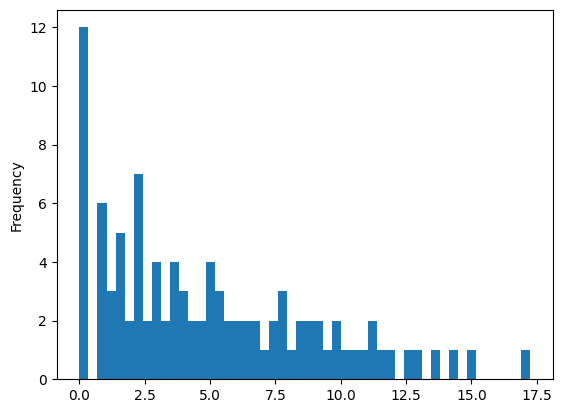

In [4]:
np.log(df.time_diff.value_counts()).plot.hist(bins = 50)

In [5]:
#meow moew

In [9]:
target = pd.read_csv("baseline.csv",index_col="Unnamed: 0")



gb = df.groupby(by=['stock_id', 'time_id']).agg({"size":"sum", "spread": "mean","time_diff":"max"})
gb['log_time_diff'] = np.log(gb.time_diff)

In [11]:
target = target.merge(gb.reset_index())

In [12]:
avg_per_stock = target.groupby('stock_id')['log_time_diff'].transform('mean')

In [23]:
target['timefunc'] = np.abs(target['log_time_diff']- avg_per_stock)**.5


#timef = gb.apply(func = timefunc, axis=1)

In [24]:
target.timefunc.describe()

count    428910.000000
mean          0.569108
std           0.246952
min           0.041650
25%           0.376883
50%           0.567450
75%           0.749598
max           1.651136
Name: timefunc, dtype: float64

<Axes: ylabel='Frequency'>

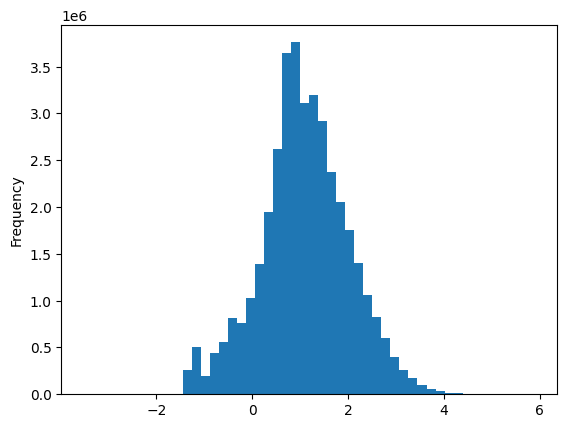

In [28]:
np.log(df.spread).plot.hist(bins = 50)

<Axes: ylabel='Frequency'>

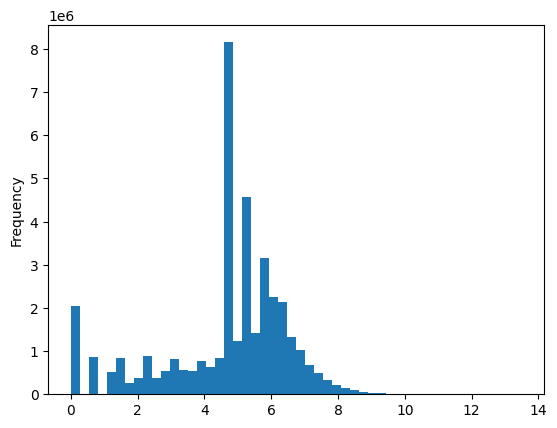

In [29]:
pd.Series(np.log(df['size'])).plot.hist(bins = 50)

<Axes: xlabel='spread', ylabel='target'>

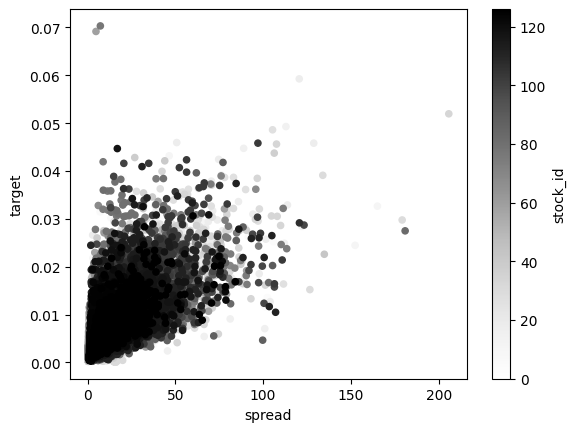

In [30]:
target.plot.scatter(x="spread", y="target",c= "stock_id")
#spread very high corr with vol. unsurprising

array([[<Axes: xlabel='sigma', ylabel='sigma'>,
        <Axes: xlabel='target', ylabel='sigma'>,
        <Axes: xlabel='size', ylabel='sigma'>,
        <Axes: xlabel='spread', ylabel='sigma'>,
        <Axes: xlabel='time_diff', ylabel='sigma'>,
        <Axes: xlabel='sqrt_size', ylabel='sigma'>,
        <Axes: xlabel='timef', ylabel='sigma'>],
       [<Axes: xlabel='sigma', ylabel='target'>,
        <Axes: xlabel='target', ylabel='target'>,
        <Axes: xlabel='size', ylabel='target'>,
        <Axes: xlabel='spread', ylabel='target'>,
        <Axes: xlabel='time_diff', ylabel='target'>,
        <Axes: xlabel='sqrt_size', ylabel='target'>,
        <Axes: xlabel='timef', ylabel='target'>],
       [<Axes: xlabel='sigma', ylabel='size'>,
        <Axes: xlabel='target', ylabel='size'>,
        <Axes: xlabel='size', ylabel='size'>,
        <Axes: xlabel='spread', ylabel='size'>,
        <Axes: xlabel='time_diff', ylabel='size'>,
        <Axes: xlabel='sqrt_size', ylabel='size'>,
        <A

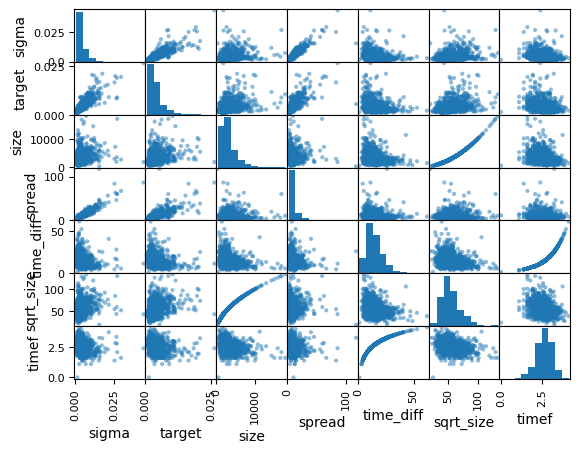

In [37]:

pd.plotting.scatter_matrix(target.head(1000).drop(columns=['stock_id','time_id']))

#Size low corr with sigma: prob due to low corr size ~ volume

In [ ]:
target.plot.scatter(x= "timefunc", y = "target", c="stock_id")

#Hmm very liquid mala sigma, illiquid tez, mid liquid duze zmiany?

<Axes: xlabel='timefunc', ylabel='target'>

In [ ]:
target.corr().target.sort_values()
#cool

In [14]:
target.to_csv("baseline2.csv")
df.to_parquet("clean_trades.parquet", engine='fastparquet')